# Model Report

In [1]:
import re
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Tuple

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

from src.command_line_interfaces import cli_helpers
from src.modeling.simulation_based_calibration_helpers import SBCFileManager

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL`: which model was tested
- `MODEL_NAME`: unique, identifiable name of the model
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found

## Setup

### Papermill parameters

In [2]:
MODEL = ""
MODEL_NAME = ""
SBC_RESULTS_DIR = ""
NUM_SIMULATIONS = -1

In [3]:
# Parameters
MODEL = "crc_ceres_mimic"
MODEL_NAME = "CERES-copynumber"
SBC_RESULTS_DIR = (
    "/n/scratch3/users/j/jc604/speclet-sbc/crc_ceres_mimic_CERES-copynumber"
)
NUM_SIMULATIONS = 500

### Prepare and validate papermill parameters

Build the model using the `MODEL` parameter.

In [4]:
ModelClass = cli_helpers.get_model_class(cli_helpers.ModelOption[MODEL])

Check values passed as the directory with results of the rounds of SBC.

In [5]:
sbc_results_dir = Path("../..", SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

Confirm that there is a positive number of simulations.

In [6]:
assert NUM_SIMULATIONS > 0

## Read in all results

In [7]:
def split_parameter(p: str) -> List[str]:
    return [a for a in re.split("\\[|,|\\]", p) if a != ""]


def get_prior_value_using_index_list(ary: np.ndarray, idx: List[int]) -> float:
    if len(idx) == 0:
        return ary

    assert len(idx) == len(ary.shape)
    value = ary
    for i in idx:
        value = value[i]
    return value


def make_priors_dataframe(
    priors: Dict[str, np.ndarray], parameters: List[str]
) -> pd.DataFrame:
    df = pd.DataFrame({"parameter": parameters, "true_value": 0}).set_index("parameter")
    for parameter in parameters:
        split_p = split_parameter(parameter)
        param = split_p[0]
        idx = [int(i) for i in split_p[1:]]
        value = get_prior_value_using_index_list(priors[param][0], idx)
        df.loc[parameter] = value
    return df

In [8]:
simulation_posteriors = []

for sbc_dir in sbc_results_dir.iterdir():
    sbc_fm = SBCFileManager(sbc_dir)
    if not sbc_fm.all_data_exists():
        raise Exception(f"Not all output from '{sbc_fm.dir.name}' exist.")
    res = sbc_fm.get_sbc_results()
    true_values = make_priors_dataframe(
        res.priors, parameters=res.posterior_summary.index.values
    )
    posterior_summary = res.posterior_summary.merge(
        true_values, left_index=True, right_index=True
    )
    simulation_posteriors.append(posterior_summary)

In [9]:
if len(simulation_posteriors) == NUM_SIMULATIONS:
    print("Collected all simulations.")
else:
    print(
        f"The number of simluations ({NUM_SIMULATIONS}) does not match the number collected ({len(simulation_posteriors)})."
    )

Collected all simulations.


## Analysis

In [10]:
def get_hdi_colnames_from_az_summary(df: pd.DataFrame) -> Tuple[str, str]:
    cols: List[str] = [c for c in df.columns if "hdi_" in c]
    cols = [c for c in cols if "%" in c]
    assert len(cols) == 2
    return cols[0], cols[1]


def is_true_value_within_hdi(
    low_hdi: pd.Series, true_vals: pd.Series, high_hdi: pd.Series
) -> np.ndarray:
    return (
        (low_hdi.values < true_vals.values).astype(int)
        * (true_vals.values < high_hdi.values).astype(int)
    ).astype(bool)


def assign_column_for_within_hdi(
    df: pd.DataFrame, true_value_col: str = "true_value"
) -> pd.DataFrame:
    hdi_low, hdi_high = get_hdi_colnames_from_az_summary(df)
    df["within_hdi"] = is_true_value_within_hdi(
        df[hdi_low], df["true_value"], df[hdi_high]
    )
    return df


def measure_posterior_accuracy(df: pd.DataFrame) -> float:
    return assign_column_for_within_hdi(df)["within_hdi"].mean()

In [11]:
hdi_acc = [measure_posterior_accuracy(p) for p in simulation_posteriors]

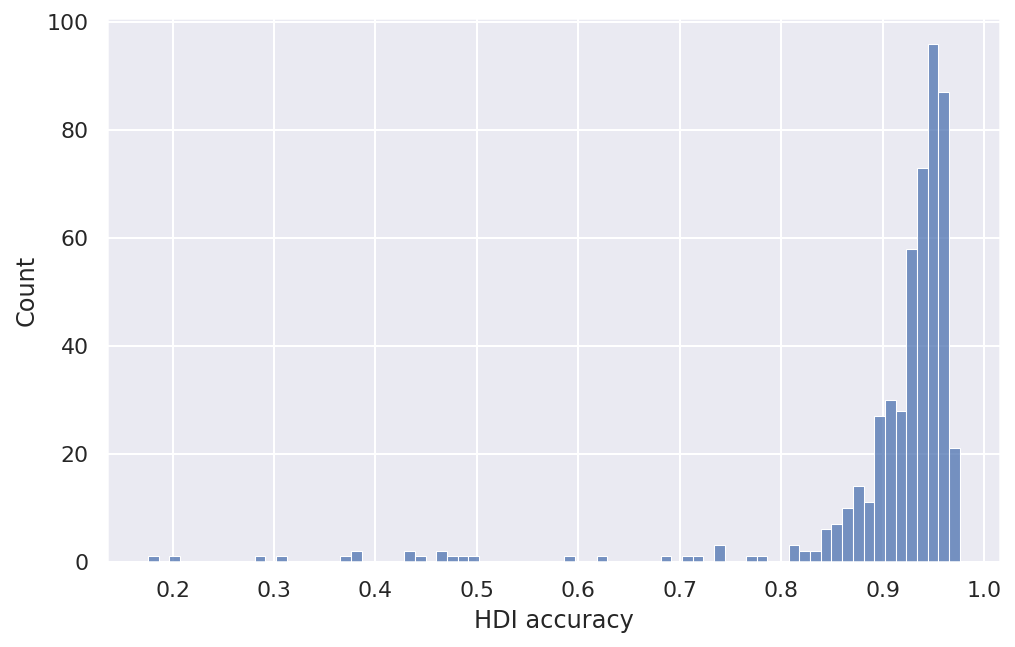

In [12]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(hdi_acc, ax=ax)
ax.set_xlabel("HDI accuracy")
plt.show()

In [13]:
simulation_posteriors_df = pd.concat(
    [
        d.assign(simulation_id=f"sim_id_{str(i).rjust(4, '0')}")
        for i, d in enumerate(simulation_posteriors)
    ]
)
simulation_posteriors_df["parameter_name"] = [
    x.split("[")[0] for x in simulation_posteriors_df.index.values
]
simulation_posteriors_df = simulation_posteriors_df.set_index(
    "parameter_name", append=True
).pipe(assign_column_for_within_hdi)

simulation_posteriors_df.head()

,,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,within_hdi,simulation_id
parameter,parameter_name,,,,,,,,,,,,
μ_h,μ_h,0.606,0.056,0.510,0.690,0.002,0.001,906.0,996.0,NaN,1.757625,False,sim_id_0000
μ_d,μ_d,0.039,0.015,0.018,0.066,0.000,0.000,1001.0,787.0,NaN,-0.127048,False,sim_id_0000
μ_η,μ_η,0.099,0.100,-0.057,0.255,0.003,0.002,1001.0,880.0,NaN,-0.020091,True,sim_id_0000
h[0],h,0.777,0.270,0.283,1.157,0.009,0.006,954.0,846.0,NaN,2.149274,False,sim_id_0000
h[1],h,1.351,0.266,0.954,1.789,0.008,0.006,1044.0,1026.0,NaN,2.654335,False,sim_id_0000


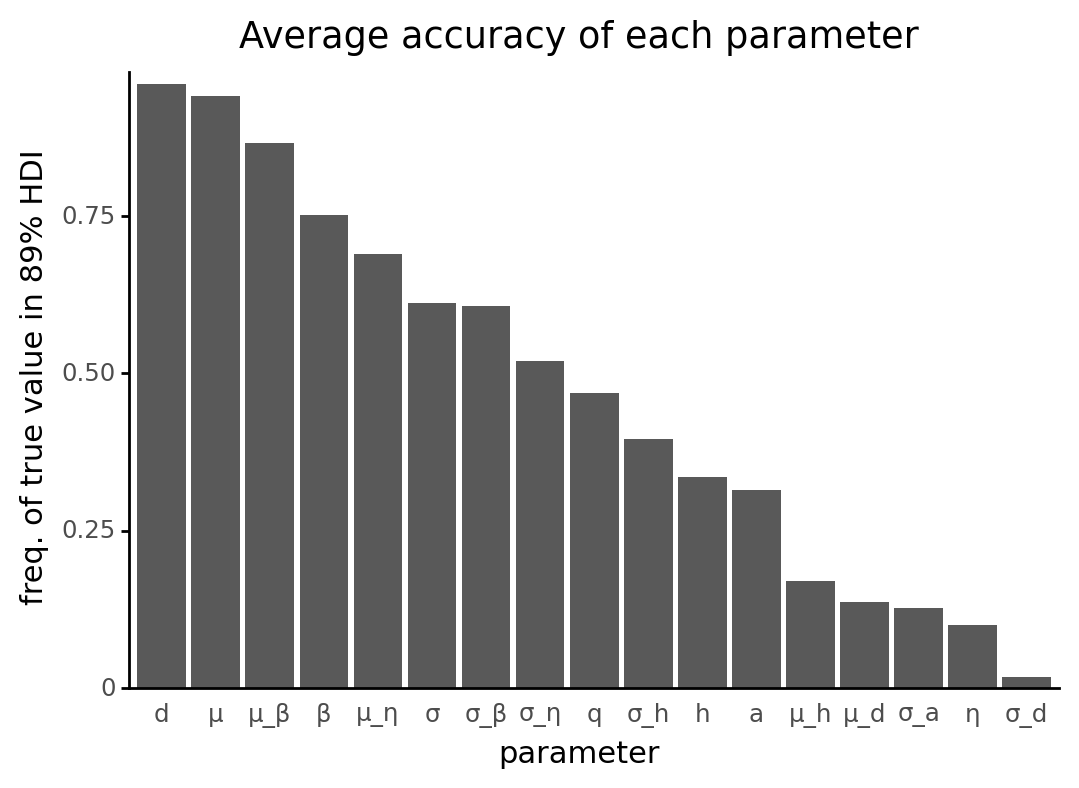

<ggplot: (2953610760467)>

In [14]:
accuracy_per_parameter = (
    simulation_posteriors_df.copy()
    .groupby(["parameter_name"])["within_hdi"]
    .mean()
    .reset_index(drop=False)
    .sort_values("within_hdi", ascending=False)
    .reset_index(drop=True)
)

accuracy_per_parameter["parameter_name"] = pd.Categorical(
    accuracy_per_parameter["parameter_name"],
    categories=accuracy_per_parameter["parameter_name"].values,
)

(
    gg.ggplot(accuracy_per_parameter, gg.aes(x="parameter_name", y="within_hdi"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="parameter",
        y="freq. of true value in 89% HDI",
        title="Average accuracy of each parameter",
    )
    + gg.theme(axis_ticks_major_x=gg.element_blank(), figure_size=(6, 4))
)

/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/f4a519a1/lib/python3.9/site-packages/mizani/bounds.py:456: RuntimeWarning: overflow encountered in double_scalars


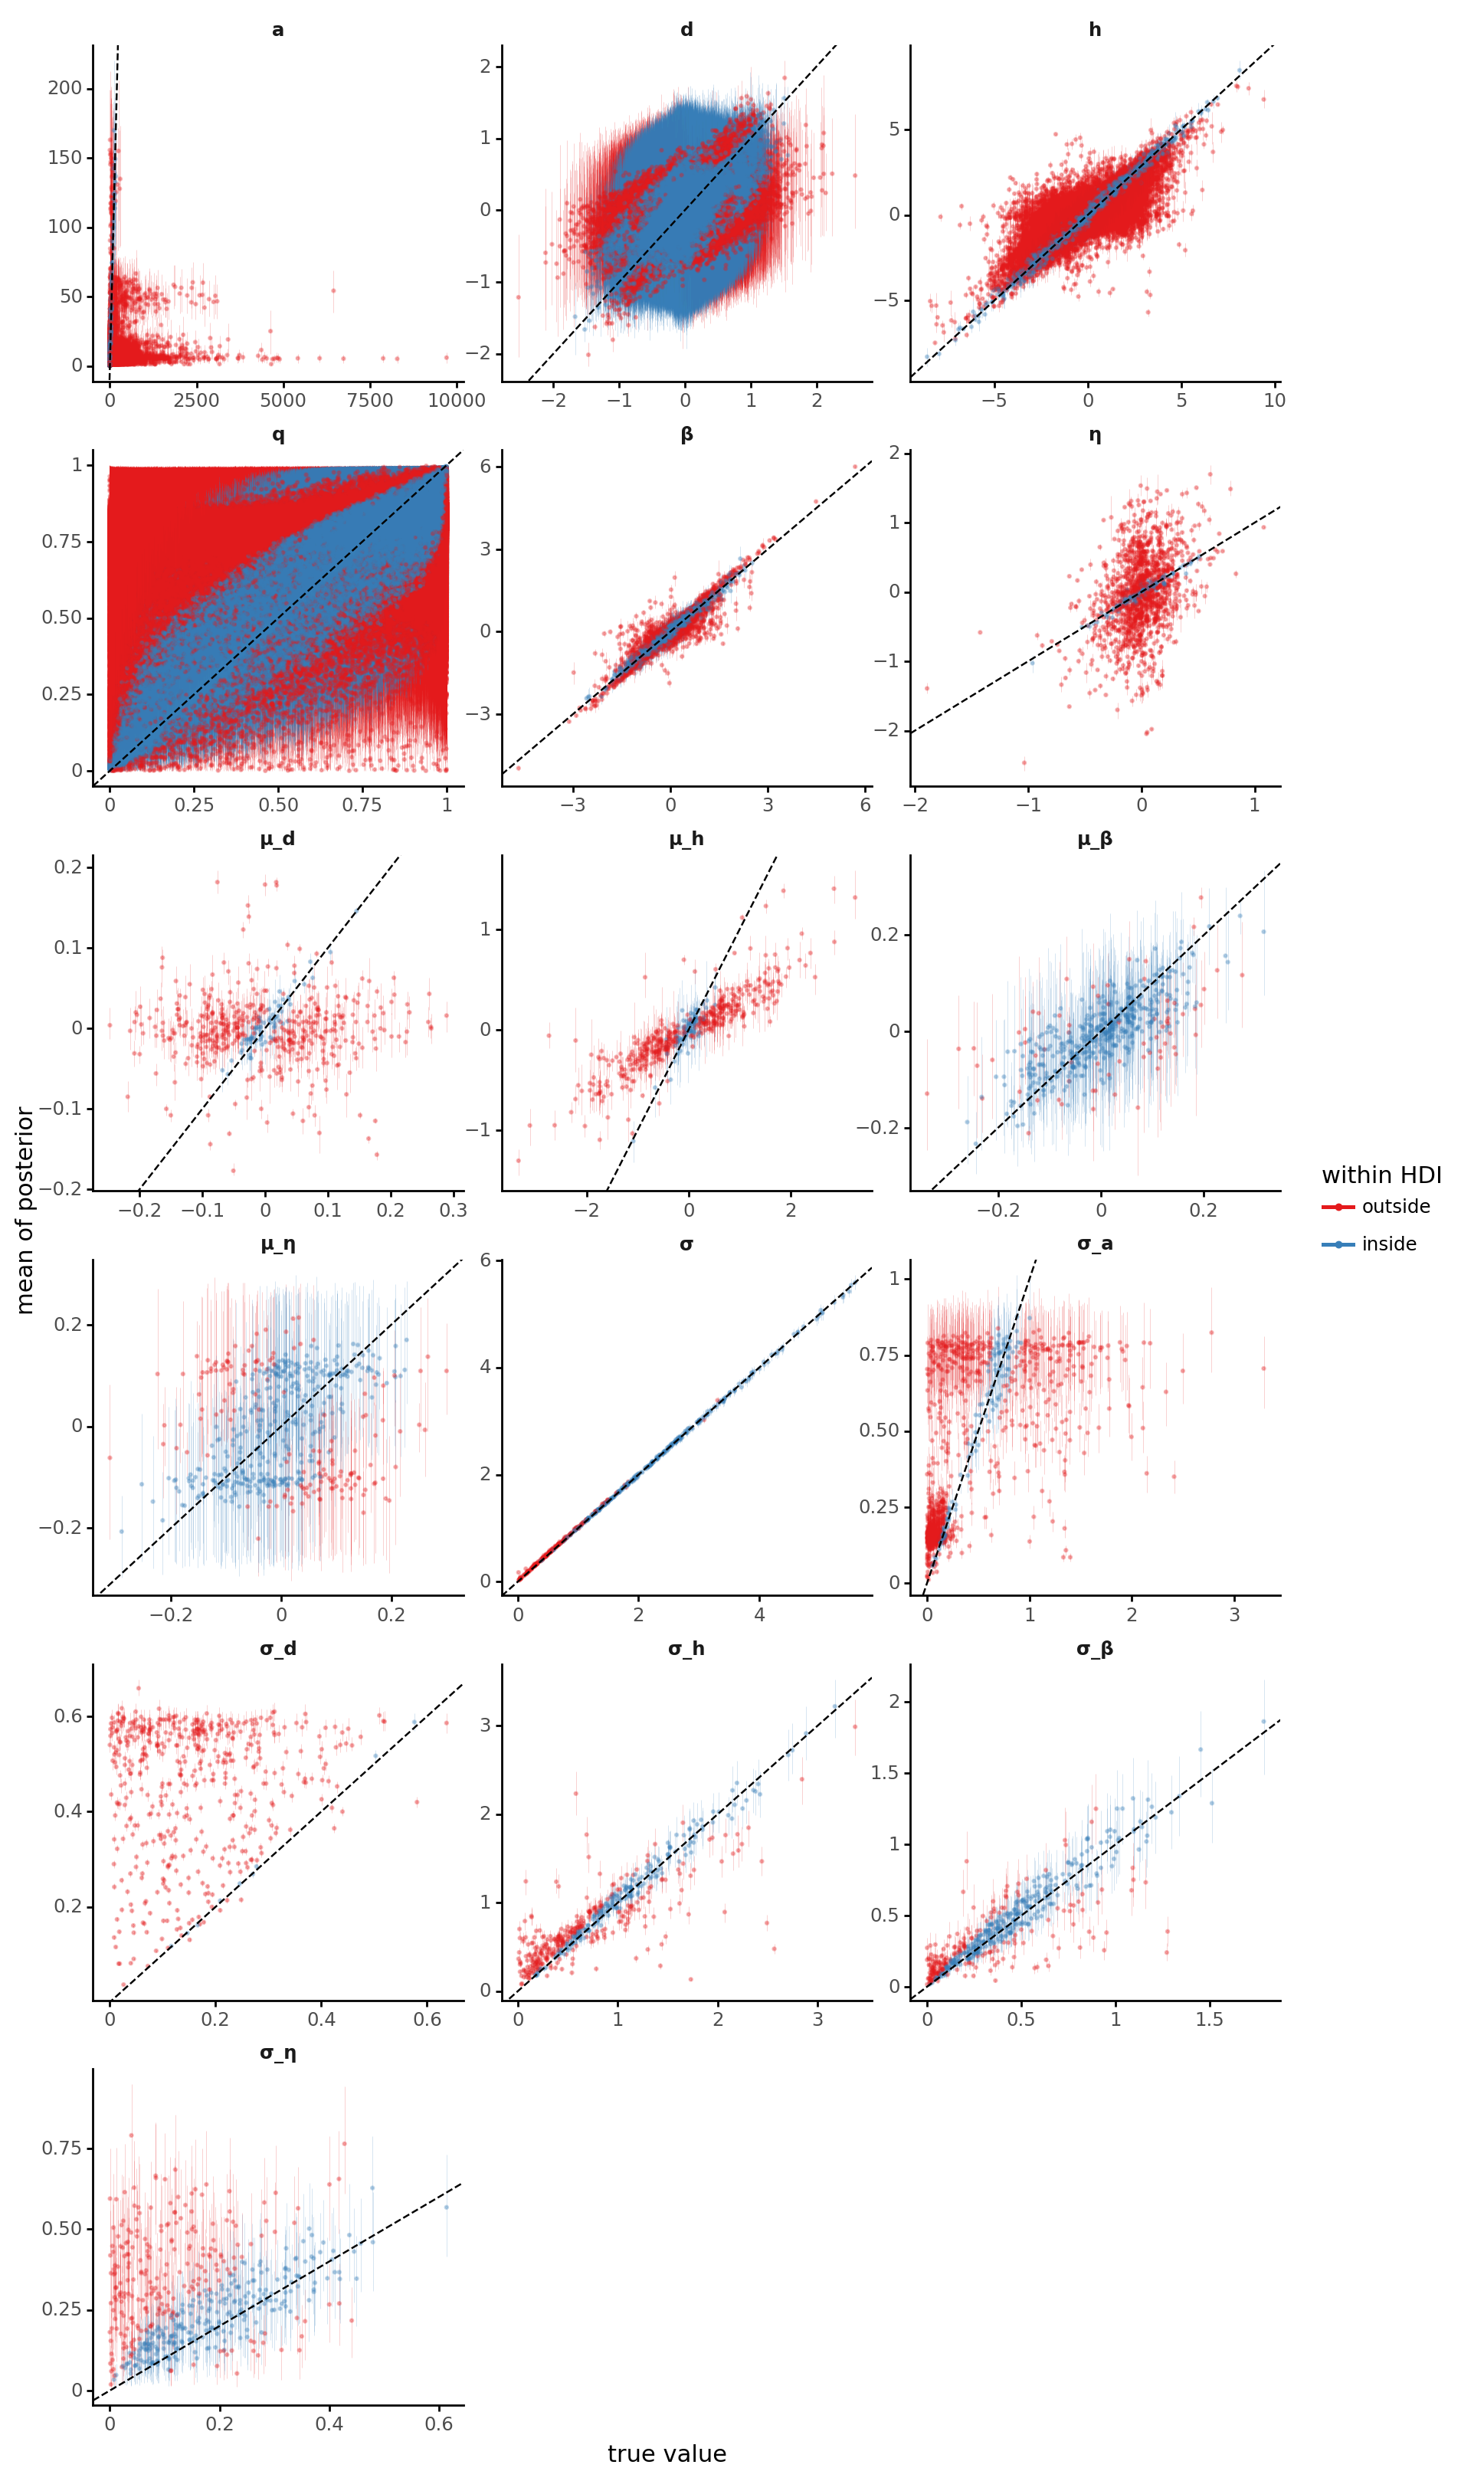

<ggplot: (2953598074182)>

In [15]:
hdi_low, hdi_high = get_hdi_colnames_from_az_summary(simulation_posteriors_df)

(
    gg.ggplot(
        simulation_posteriors_df.reset_index(drop=False).query("parameter_name != 'μ'"),
        gg.aes(x="true_value", y="mean", color="within_hdi"),
    )
    + gg.facet_wrap("~ parameter_name", ncol=3, scales="free")
    + gg.geom_linerange(gg.aes(ymin=hdi_low, ymax=hdi_high), alpha=0.2, size=0.2)
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        labels=("outside", "inside"),
        guide=gg.guide_legend(
            title="within HDI",
            override_aes={"alpha": 1, "size": 1},
        ),
    )
    + gg.theme(
        figure_size=(10, 20),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        panel_spacing=0.25,
    )
    + gg.labs(
        x="true value",
        y="mean of posterior",
    )
)

---

In [16]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 17.34 minutes


In [17]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-04-19

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-243.o2.rc.hms.harvard.edu

Git branch: pipelines

plotnine  : 0.7.1
re        : 2.2.1
numpy     : 1.20.1
pandas    : 1.2.3
arviz     : 0.11.2
pymc3     : 3.11.1
matplotlib: 3.3.4
seaborn   : 0.11.1

